In [2]:
import pandas as pd
import numpy as np
from scipy.stats import truncnorm
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import random
import conditionalconformal
from conditionalconformal import CondConf
import itertools
import math
from numpy import sin, cos, exp
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Dropout, LeakyReLU
from tensorflow.keras.regularizers import l2
from matplotlib.patches import Patch
from scipy.spatial import ConvexHull


In [3]:
np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

dimension_z = 20
dimension_x = 20
number_z = 50
# Generating 50 vectors, each with 100 dimensions
z_domain = np.random.normal(size=(number_z, dimension_z))

# Generating beta_1 and beta_2
beta_1 = np.random.uniform(-0.5, 0.5, dimension_x)
beta_2 = np.random.uniform(-0.5, 0.5, dimension_z)


In [4]:

def generate_function(beta_1, beta_2):

    def function_2(X, Z):
        epsilon = np.random.uniform(-1, 1)

        T = exp(np.dot(beta_1.T, X))*np.dot(beta_2.T, Z) + exp(np.cos(np.dot(X, Z))**2) * (epsilon)
        return T


    return function_2

function_2 = generate_function(beta_1, beta_2)


In [5]:
def phi_fn(feature):
    scalar_values = np.array(feature[:,dimension_x:(dimension_x+dimension_z)])#len 500

    # Initialize the indicator matrix
    matrix = np.zeros((len(np.array(feature[:,1])), number_z))

    # Fill in the indicator matrix
    for i, value in enumerate(scalar_values):
        for j in range(0, number_z):
            if  np.array_equal(value, z_domain[j]):
                matrix[i, j] = 1

    return matrix

In [6]:
# Function to combine X and Z into a single flattened array
flatten_features = lambda df: np.array([np.concatenate([x, z]) for x, z in zip(df['X'], df['Z'])])

In [7]:
np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)
Z_new = z_domain[np.random.randint(z_domain.shape[0])]
var_x = 1
def conformal_predict_z_0(alpha=0.1, m=100, Z_new=Z_new, N=1000, t=200):
    IR = []
    for j in range(t):
        data_points = []
        for _ in range(N):
            # Randomly select a vector from z_domain to be Z
            Z = z_domain[np.random.randint(z_domain.shape[0])]

            # Compute the mean of the square of Z
            mean_x = np.mean(Z**2)

            # Generate a 100-dimensional vector X from a normal distribution with mean mean_x and variance 1
            X = np.random.normal(mean_x, var_x, dimension_x)

            # Compute T_1 the generated functions
            T_1 = function_2(X, Z)

            # Append the data point (X, Z, T_1) to the list
            data_points.append([X, Z, T_1])
        # Split the data into D_cali and D_train
        D_cali = pd.DataFrame(data_points[:N//2], columns=["X", "Z", "T_1"])
        D_train = pd.DataFrame(data_points[N//2:], columns=["X", "Z", "T_1"])

        # Preparing data for regression
        X_train = flatten_features(D_train)
        # Extracting T_1 for D_train and D_cali
        Y_train = D_train['T_1'].values
        # Build a neural network model
        model_nn = Sequential([
            InputLayer(input_shape=(X_train.shape[1],)),   
            Dense(128, activation=LeakyReLU(alpha=0.01), kernel_regularizer=l2(0.02)), # Use LeakyReLU and L2 regularization
            Dropout(0.3),
            Dense(64, activation=LeakyReLU(alpha=0.01), kernel_regularizer=l2(0.02)),
            Dense(1)               
        ])
 
        # Compilation model
        model_nn.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

        # train the model on D train
        history = model_nn.fit(X_train, Y_train, epochs=15, batch_size=32, verbose=0)
        
        score_fn = lambda feature,  y : abs(y - model_nn.predict(feature).flatten())
        condCovProgram = CondConf(score_fn, phi_fn, {})
        condCovProgram.setup_problem(flatten_features(D_cali),D_cali['T_1'].to_numpy())
        
        data_points_new = []
        for _ in range(m):
            # Compute the mean of the square of Z
            mean_x_new = np.mean(Z_new**2)
            # Generate a 100-dimensional vector X from a normal distribution with mean mean_x_new and variance 1
            X_new = np.random.normal(mean_x_new, var_x, dimension_x)
            # Compute T_1 using the generated functions
            T_1_new = function_2(X_new, Z_new)

            # Append the data point (X, Z, T_1) to the list
            data_points_new.append([X_new, Z_new, T_1_new])

        # Split the data into D_cali and D_train
        D_new = pd.DataFrame(data_points_new, columns=["X", "Z", "T_1"])
        
        X_neww = flatten_features(D_new)
        T_1_new= D_new['T_1']
        T_1_pred_new = model_nn.predict(X_neww).flatten()

        Xtest = np.array([flatten_features(D_new)[10,:]])
        d = condCovProgram.predict(1-alpha, Xtest, lambda x, y : x)
        
        # Calculate intervals
        hat_t_L = T_1_pred_new - d
        hat_t_U = T_1_pred_new + d 
        IR.append(np.mean((hat_t_L <= T_1_new) & (T_1_new <= hat_t_U)))
             
    return IR, d


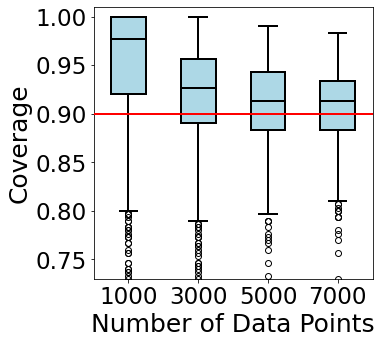

In [9]:
np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)
Z_new = z_domain[np.random.randint(z_domain.shape[0])]
IR_1000, d_1000 = conformal_predict_z_0(alpha=0.1, m=300, Z_new=Z_new, N=1000, t=1000)

np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)
Z_new = z_domain[np.random.randint(z_domain.shape[0])]
IR_3000, d_3000 = conformal_predict_z_0(alpha=0.1, m=300, Z_new=Z_new, N=3000, t=1000)


np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)
Z_new = z_domain[np.random.randint(z_domain.shape[0])]
IR_5000, d_5000 = conformal_predict_z_0(alpha=0.1, m=300, Z_new=Z_new, N=5000, t=1000)

np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)
Z_new = z_domain[np.random.randint(z_domain.shape[0])]
IR_7000, d_7000 = conformal_predict_z_0(alpha=0.1, m=300, Z_new=Z_new, N=7000, t=1000)


N_values = [1000, 3000, 5000, 7000]

fig = plt.figure(figsize=(5, 5))
plt.boxplot([IR_1000,IR_3000, IR_5000, IR_7000], patch_artist=True, 
            medianprops=dict(color="black", linewidth=2,zorder=4),  
            boxprops=dict(facecolor='lightblue', linewidth=2),  
            whiskerprops=dict(linewidth=2),  
            capprops=dict(linewidth=2),widths=0.5, labels=N_values)  

plt.yticks( fontsize=23)
plt.xticks([1], [''])  # Setting x-axis label to an empty string

plt.xlabel("Number of Data Points", fontsize=25)
plt.ylabel('Coverage', fontsize=25)
plt.xticks(range(1, len(N_values) + 1), N_values, fontsize=23)
plt.ylim(0.73,1.01)
plt.axhline(y=0.9, color='red', linestyle='-', label='', linewidth=2,zorder=3)

In [10]:
def create_coordinates(v):
    m = len(v)
    coordinates = np.zeros((m, 2))  
    for j in range(m):
        coordinates[j, 0] = (2 * j + 1) / (2 * m) 
        coordinates[j, 1] = (2 * j + 1) * v[j] / (2 * m)  

    return coordinates

def get_slope(x, hull_points, slopes):
    for i in range(len(hull_points) - 1):
        x1, x2 = hull_points[i][0], hull_points[i + 1][0]
        if x1 <= x <= x2:
            if x == x2 and i < len(slopes) - 1:
                return max(slopes[i], slopes[i + 1])
            if x == x1 and i > 0:
                return max(slopes[i - 1], slopes[i])
            return slopes[i]
    return None


def find_last_min_non_negative_index(nums):
    min_non_neg = float('inf') 
    min_index = -1 
    for i, num in enumerate(nums):
        if num >= 0 and num <= min_non_neg:
            min_non_neg = num
            min_index = i

    return min_index


def myerson_reserve(table):
    sorted_bids = np.sort(table["T_1"])[::-1]  
    new_vector_1 = create_coordinates(sorted_bids)
    new_points = np.array([[0, 0], [1, 0]])
    new_vector_1 = np.concatenate((new_points[0:1], new_vector_1, new_points[1:2]), axis=0)
    points = new_vector_1
    hull = ConvexHull(points)
    hull_points = points[hull.vertices]
    hull_points = hull_points[hull_points[:, 0].argsort()]

    slopes = []
    for i in range(len(hull_points) - 1):
        x1, y1 = hull_points[i]
        x2, y2 = hull_points[i + 1]
        slope = (y2 - y1) / (x2 - x1)
        slopes.append(slope)

    point_slopes = []
    for point in points:
        x = point[0]
        slope = get_slope(x, hull_points, slopes)
        point_slopes.append(slope)
        
    index_reserve = find_last_min_non_negative_index(point_slopes[1:-1])
    return sorted_bids[index_reserve]

In [11]:
np.random.seed(1)
Z_new = z_domain[np.random.randint(z_domain.shape[0])]
var = 1
def conformal_predict(alpha=0.1, m=100, Z_new=Z_new, reserve_price=0):

    data_points_new = []
    for _ in range(m):
        # Compute the mean of the square of Z
        mean_x_new = np.mean(Z_new**2)
        # Generate a 100-dimensional vector X from a normal distribution with mean mean_x_new and variance 1
        X_new = np.random.normal(mean_x_new, var, dimension_x)
        # Compute T_1  using the generated functions
        T_1_new = function_2(X_new, Z_new)
        
        data_points_new.append([X_new, Z_new, T_1_new])

    # Split the data into D_cali and D_train
    D_new = pd.DataFrame(data_points_new, columns=["X", "Z", "T_1"])

    X_neww = flatten_features(D_new)
    T_1_new= D_new['T_1']
    T_1_pred_new = model_nn.predict(X_neww).flatten()

    Xtest = np.array([flatten_features(D_new)[10,:]])
    d = condCovProgram.predict(1-alpha, Xtest, lambda x, y : x)
     
    reserve_price = T_1_pred_new - d
    virtual_value = np.array(T_1_new) * (np.array(T_1_new) >= reserve_price)

    # Find the index(es) of the maximum virtual value
    max_virtual_value_indexes = np.where(virtual_value == np.max(virtual_value))[0]
    winner = None
    if len(max_virtual_value_indexes) > 1:
    # Check the reserve price for the max virtual value indexes
        max_reserve_price_indexes = np.where(reserve_price[max_virtual_value_indexes] == np.max(reserve_price[max_virtual_value_indexes]))[0]

        if len(max_reserve_price_indexes) > 1:
        # If multiple maximums, choose one at random
            winner = np.random.choice(max_virtual_value_indexes[max_reserve_price_indexes])
        else:
        # If only one maximum
            winner = max_virtual_value_indexes[max_reserve_price_indexes[0]]
    else:
    # If only one maximum virtual value
        winner = max_virtual_value_indexes[0]

    sorted_virtual_value = np.sort(virtual_value)[::-1]
    payment = max(0, sorted_virtual_value[1], reserve_price[winner])
    max_welfare = np.max(np.array(T_1_new))
    
    sb_value = np.sort(np.array(T_1_new))[::-1][1] if len(np.sort(np.array(T_1_new))[::-1]) >= 2 else 0
    myerson_value = np.maximum(np.sort(np.array(T_1_new))[::-1][1], myerson_reserve_price) if np.sort(np.array(T_1_new))[::-1][0] >= myerson_reserve_price else 0

    
    return payment, myerson_value, sb_value, max_welfare

In [ ]:
np.random.seed(1)
Z_new = z_domain[np.random.randint(z_domain.shape[0])]
import logging
import absl.logging
np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

N_values = [3000, 11000, 20000, 30000]
num_runs = 1000

# Initializes the dictionary used to store the results
results_list = []  

# For each value of N, run the function 1000 times and calculate the average
for N in N_values:
    data_points = []
    for _ in range(N):
        # Randomly select a vector from z_domain to be Z
        Z = z_domain[np.random.randint(z_domain.shape[0])]

        # Compute the mean of the square of Z
        mean_x = np.mean(Z**2)

        # Generate a 100-dimensional vector X from a normal distribution with mean mean_x and variance 1
        X = np.random.normal(mean_x, var, dimension_x)

        # Compute T_1 using the generated functions
        T_1 = function_2(X, Z)

        # Append the data point (X, Z, T_1) to the list
        data_points.append([X, Z, T_1])

    
    ############################################## The Empirical Myerson Auction
    D_myerson = pd.DataFrame(data_points, columns=["X", "Z", "T_1"])
    df_myerson =  D_myerson[D_myerson["Z"].apply(lambda z: np.array_equal(z, Z_new))]
    myerson_reserve_price = myerson_reserve(df_myerson)
    ##############################################
   
    # Split the data into D_cali and D_train    
    D_cali = pd.DataFrame(data_points[:N//2], columns=["X", "Z", "T_1"])
    D_train = pd.DataFrame(data_points[N//2:], columns=["X", "Z", "T_1"])

    X_train = flatten_features(D_train)
    # Extracting T_1 for D_train and D_cali
    Y_train = D_train['T_1'].values
    model_nn = Sequential([
        InputLayer(input_shape=(X_train.shape[1],)),   
        Dense(128, activation=LeakyReLU(alpha=0.01), kernel_regularizer=l2(0.02)), 
        Dropout(0.3),
        Dense(64, activation=LeakyReLU(alpha=0.01), kernel_regularizer=l2(0.02)),
        Dense(1)                        
    ])
    
    model_nn.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    history = model_nn.fit(X_train, Y_train, epochs=15, batch_size=32, verbose=0)
    score_fn = lambda feature,  y : abs(y - model_nn.predict(feature).flatten())
    condCovProgram = CondConf(score_fn, phi_fn, {})
    condCovProgram.setup_problem(flatten_features(D_cali),D_cali['T_1'].to_numpy())
    
    payments, myerson_values, sb_values, max_welfares = [], [], [], []
    for _ in range(num_runs):
        payment, myerson_value, sb_value, max_welfare = conformal_predict(0.1, 300, Z_new, myerson_reserve_price)
        payments.append(payment)
        myerson_values.append(myerson_value)
        sb_values.append(sb_value)
        max_welfares.append(max_welfare)
     # Store the results for each N in a separate dictionary
    results = {"N": N, "payment": payments, "myerson_values": myerson_values, "sb_value": sb_values, "max_welfare":max_welfares}
    results_list.append(results)

    

In [13]:
N_values = []
payments_means, payments_stds = [], []
sb_values_means, sb_values_stds = [], []
max_welfare_means, max_welfare_stds = [], []
myerson_means, myerson_stds = [], []


for entry in results_list:
    N_values.append(entry['N'])
    payments_means.append(np.mean(entry['payment']))
    payments_stds.append(1.96*np.std(entry['payment']) / np.sqrt(len(entry['payment'])))
    sb_values_means.append(np.mean(entry['sb_value']))
    sb_values_stds.append(1.96*np.std(entry['sb_value']) / np.sqrt(len(entry['sb_value'])))
    max_welfare_means.append(np.mean(entry['max_welfare']))
    max_welfare_stds.append(1.96*np.std(entry['max_welfare']) / np.sqrt(len(entry['max_welfare'])))
    myerson_means.append(np.mean(entry['myerson_values']))
    myerson_stds.append(1.96*np.std(entry['myerson_values']) / np.sqrt(len(entry['myerson_values'])))
    

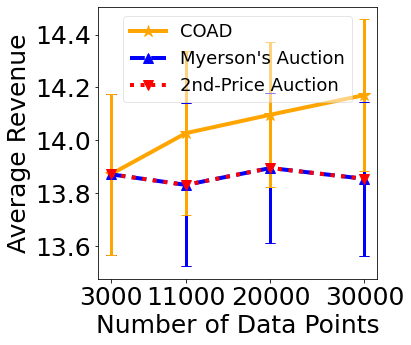

In [14]:
plt.figure(figsize=(5,5)) 

plt.plot(N_values, payments_means,label="COAD", color='orange', linestyle='-', marker='*', linewidth=4,markersize=12)
plt.plot(N_values, myerson_means, label="Myerson's Auction", color='blue', linestyle='--', marker='^', linewidth=4,markersize=10)
plt.plot(N_values, sb_values_means, label="2nd-Price Auction", color='red', linestyle=':', marker='v', linewidth=4,markersize=10)


plt.errorbar(N_values, sb_values_means, yerr=sb_values_stds, fmt='none', ecolor='red',capsize=5, elinewidth=3)
plt.errorbar(N_values, myerson_means, yerr=myerson_stds, fmt='none', ecolor='blue',capsize=5, elinewidth=3)
plt.errorbar(N_values, payments_means, yerr=payments_stds, fmt='none', ecolor='orange', capsize=5, elinewidth=3)

plt.xlabel("Number of Data Points", fontsize=25)
plt.ylabel("Average Revenue", fontsize=25)
plt.legend(fontsize=18, facecolor='white', framealpha=0.5)
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
plt.xticks([3000,11000, 20000, 30000])
plt.show()


In [ ]:
np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)
Z_new = z_domain[np.random.randint(z_domain.shape[0])]
var_x = 1
data_points = []
N = 50000
for _ in range(N):
    # Randomly select a vector from z_domain to be Z
    Z = z_domain[np.random.randint(z_domain.shape[0])]

    # Compute the mean of the square of Z
    mean_x = np.mean(Z**2)

    # Generate a 100-dimensional vector X from a normal distribution with mean mean_x and variance 1
    X = np.random.normal(mean_x, var_x, dimension_x)

    # Compute T_1 using the generated functions
    T_1 = function_2(X, Z)

    # Append the data point (X, Z, T_1) to the list
    data_points.append([X, Z, T_1])
# Split the data into D_cali and D_train
D_cali = pd.DataFrame(data_points[:N//2], columns=["X", "Z", "T_1"])
D_train = pd.DataFrame(data_points[N//2:], columns=["X", "Z", "T_1"])

############################################## The Empirical Myerson Auction
D_myerson = pd.DataFrame(data_points, columns=["X", "Z", "T_1"])
df_myerson =  D_myerson[D_myerson["Z"].apply(lambda z: np.array_equal(z, Z_new))]
myerson_reserve_price = myerson_reserve(df_myerson)
##############################################

# Preparing data for regression
X_train = flatten_features(D_train)
# Extracting T_1 for D_train and D_cali
Y_train = D_train['T_1'].values
# Build a neural network model
model_nn = Sequential([
    InputLayer(input_shape=(X_train.shape[1],)),   
    Dense(128, activation=LeakyReLU(alpha=0.01), kernel_regularizer=l2(0.02)), # Use LeakyReLU and L2 regularization
    Dropout(0.3),
    Dense(64, activation=LeakyReLU(alpha=0.01), kernel_regularizer=l2(0.02)),
    Dense(1)                    
])


model_nn.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

history = model_nn.fit(X_train, Y_train, epochs=15, batch_size=32, verbose=0)

score_fn = lambda feature,  y : abs(y - model_nn.predict(feature).flatten())
condCovProgram = CondConf(score_fn, phi_fn, {})
condCovProgram.setup_problem(flatten_features(D_cali),D_cali['T_1'].to_numpy())

def conformal_predict(alpha=0.1, m=100, Z_new=Z_new, reserve_price=myerson_reserve_price):

    data_points_new = []
    for _ in range(m):
        # Compute the mean of the square of Z
        mean_x_new = np.mean(Z_new**2)
        # Generate a 100-dimensional vector X from a normal distribution with mean mean_x and variance 1
        X_new = np.random.normal(mean_x_new, var_x, dimension_x)
        # Compute T_1 using the generated functions
        T_1_new = function_2(X_new, Z_new)

        # Append the data point (X, Z, T_1) to the list
        data_points_new.append([X_new, Z_new, T_1_new])

    # Split the data into D_cali and D_train
    D_new = pd.DataFrame(data_points_new, columns=["X", "Z", "T_1"])

    X_neww = flatten_features(D_new)
    T_1_new= D_new['T_1']
    T_1_pred_new = model_nn.predict(X_neww).flatten()

    Xtest = np.array([flatten_features(D_new)[1,:]])
    d = condCovProgram.predict(1-alpha, Xtest, lambda x, y : x)
     
    reserve_price = T_1_pred_new - d
    virtual_value = np.array(T_1_new) * (np.array(T_1_new) >= reserve_price)

    # Find the index(es) of the maximum virtual value
    max_virtual_value_indexes = np.where(virtual_value == np.max(virtual_value))[0]
    winner = None
    if len(max_virtual_value_indexes) > 1:
    # Check the reserve price for the max virtual value indexes
        max_reserve_price_indexes = np.where(reserve_price[max_virtual_value_indexes] == np.max(reserve_price[max_virtual_value_indexes]))[0]

        if len(max_reserve_price_indexes) > 1:
        # If multiple maximums, choose one at random
            winner = np.random.choice(max_virtual_value_indexes[max_reserve_price_indexes])
        else:
        # If only one maximum
            winner = max_virtual_value_indexes[max_reserve_price_indexes[0]]
    else:
    # If only one maximum virtual value
        winner = max_virtual_value_indexes[0]

    sorted_virtual_value = np.sort(virtual_value)[::-1]
    payment = max(0, sorted_virtual_value[1], reserve_price[winner])
    max_welfare = np.max(np.array(T_1_new))
    
    sb_value = np.sort(np.array(T_1_new))[::-1][1] if len(np.sort(np.array(T_1_new))[::-1]) >= 2 else 0
    myerson_value = np.maximum(np.sort(np.array(T_1_new))[::-1][1], myerson_reserve_price) if np.sort(np.array(T_1_new))[::-1][0] >= myerson_reserve_price else 0

    
    return payment, myerson_value, sb_value, max_welfare

In [15]:
# Set different values for m
m_values = [300, 350, 400, 450, 500]
np.random.seed(1)
random.seed(1)
Z_new = z_domain[np.random.randint(z_domain.shape[0])]
num_runs = 1000

# This will store the results for each m value
results_list_m = []

# For each m value, run the function 1000 times and calculate the average
for m in m_values:
    payments, myerson_values, sb_values, max_welfares = [], [], [], []
    for _ in range(num_runs):
        payment, myerson_value, sb_value, max_welfare = conformal_predict(0.1, m, Z_new)
        payments.append(payment)
        myerson_values.append(myerson_value)
        sb_values.append(sb_value)
        max_welfares.append(max_welfare)
    
    # Create a dictionary for each m with the results and append to the list
    results = {"m": m, "payment": payments, "myerson_values": myerson_values, "sb_value": sb_values, "max_welfare": max_welfares}
    results_list_m.append(results)
    


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
10/10 ━━━━━━━━━━

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
10/10 ━━━━━━━━━━

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
10/10 ━━━━━━━━━━

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
10/10 ━━━━━━━━━━

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
10/10 ━━━━━━━━━━

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
11/11 ━━━━━━━━━━

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
11/11 ━━━━━━━━━━

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
11/11 ━━━━━━━━━━

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
11/11 ━━━━━━━━━━

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step
11/11 ━━━━━━━━━━

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step
13/13 ━━━━━━━━━━

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step
13/13 ━━━━━━━━━━

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step
13/13 ━━━━━━━━━━

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
13/13 ━━━━━━━━━━

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step
15/15 ━━━━━━━━━━

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
15/15 ━━━━━━━━━━

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step
15/15 ━━━━━━━━━━

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
15/15 ━━━━━━━━━━

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step
15/15 ━━━━━━━━━━

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step
16/16 ━━━━━━━━━━

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step
16/16 ━━━━━━━━━━

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 643us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step
16/16 ━━━━━━━━━━

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step
16/16 ━━━━━━━━━━

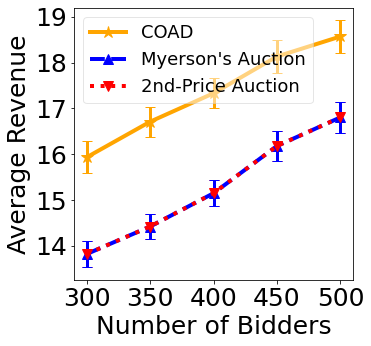

In [16]:
m_values = []
payment_means = []
payment_ses = []
sb_value_means = []
sb_value_ses = []
max_welfare_means = []
max_welfare_ses = []
myerson_means, myerson_ses = [], []

for entry in results_list_m:
    m_values.append(entry['m'])
    payment_means.append(np.mean(entry['payment']))
    payment_ses.append(1.96 * np.std(entry['payment']) / np.sqrt(len(entry['payment'])))  
    sb_value_means.append(np.mean(entry['sb_value']))
    sb_value_ses.append(1.96 * np.std(entry['sb_value']) / np.sqrt(len(entry['sb_value'])))
    max_welfare_means.append(np.mean(entry['max_welfare']))
    max_welfare_ses.append(1.96 * np.std(entry['max_welfare']) / np.sqrt(len(entry['max_welfare'])))
    myerson_means.append(np.mean(entry['myerson_values']))
    myerson_ses.append(1.96*np.std(entry['myerson_values']) / np.sqrt(len(entry['myerson_values'])))

plt.figure(figsize=(5, 5))

plt.plot(m_values, payment_means, label="COAD",  color='orange', linestyle='-', marker='*', linewidth=4,markersize=12)
plt.plot(m_values, myerson_means, label="Myerson's Auction",  color='blue', linestyle='--', marker='^', linewidth=4,markersize=10)
plt.plot(m_values, sb_value_means, label="2nd-Price Auction",  color='red', linestyle=':', marker='v', linewidth=4,markersize=10)

plt.errorbar(m_values, payment_means, yerr=payment_ses, fmt='none', ecolor='orange', capsize=5, elinewidth=3)
plt.errorbar(m_values, sb_value_means, yerr=sb_value_ses,fmt='none', ecolor='red', capsize=5, elinewidth=3)
plt.errorbar(m_values, myerson_means, yerr=myerson_ses,fmt='none', ecolor='blue', capsize=5, elinewidth=3)

plt.xlabel("Number of Bidders", fontsize=25)
plt.ylabel("Average Revenue", fontsize=25)
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
plt.xticks([300, 350, 400, 450, 500])
plt.title("")
plt.legend(fontsize=18, loc="upper left", facecolor='white', framealpha=0.5)
plt.show()

